In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install neuraloperator


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 34.5 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.9/186.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 105.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.9/203.9 kB 3.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 101.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━

In [2]:
# Cell 1: Install Dependencies (Run this first!)
# --------------------------------------------
# Ensure pip installs quietly to avoid excessive output
import os
os.environ['PIP_QUIET'] = '1'

print("Installing prerequisites...")
# Install CuPy for the likely Kaggle CUDA version (adjust if needed)
# Check CuPy docs (https://docs.cupy.dev/en/stable/install.html) for the correct wheel
# Common Kaggle versions might be CUDA 11.x or 12.x
# Trying cuda12x first, adjust if Kaggle environment uses something else
!pip install cupy-cuda12x torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu121 neuralop scikit-learn matplotlib tqdm
print("Installation attempted. Checking CuPy GPU access...")

# Verify CuPy installation and GPU detection
gpu_available = False
try:
    import cupy as cp
    cp.cuda.Device(0).use()
    import cupy as xp # Use CuPy
    print("SUCCESS: CuPy is using the GPU. Using 'cupy' as xp.")
    gpu_available = True
except ImportError:
    print("INFO: CuPy not found or import failed. Falling back to NumPy.")
    import numpy as xp # Use NumPy
except cp.cuda.runtime.CUDARuntimeError as e:
    print(f"WARNING: CuPy found, but could not use GPU: {e}")
    print("Falling back to NumPy.")
    import numpy as xp # Use NumPy

# Import other necessary libraries
import numpy as np # Keep numpy for CPU-specific tasks like SVD, final data assembly
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # Use notebook version for better display in Kaggle
import time

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from neuralop.models import FNO1d
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler # Good practice for POD coeffs

print("\nLibraries imported.")
print(f"GPU Available for LBM/Array Ops: {gpu_available}")

# Configure PyTorch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"PyTorch will use device: {device}")

Installing prerequisites...
ERROR: Could not find a version that satisfies the requirement neuralop (from versions: none)
ERROR: No matching distribution found for neuralop
Installation attempted. Checking CuPy GPU access...
SUCCESS: CuPy is using the GPU. Using 'cupy' as xp.

Libraries imported.
GPU Available for LBM/Array Ops: True
PyTorch will use device: cuda


In [3]:
# Cell 2: LBM Simulation Parameters and Functions
# -----------------------------------------------
print("Setting up LBM...")

# --- LBM Simulation Parameters ---
Re = 150.0       # Reynolds number
Nx, Ny = 400, 100 # Grid dimensions (Increase cautiously based on GPU memory)
max_iters = 40000 # Total simulation iterations
save_interval = 200 # Save snapshot every N iterations
u_lb = 0.04      # Lattice velocity
cylinder_x, cylinder_y = Nx // 5, Ny // 2 # Cylinder position
cylinder_r = Ny // 9 # Cylinder radius

# --- LBM Derived Parameters ---
nu_lb = u_lb * 2.0 * cylinder_r / Re # Lattice viscosity
tau = 3.0 * nu_lb + 0.5            # Relaxation time
if tau <= 0.5:
    print(f"Warning: tau = {tau:.3f} is low (instability risk). Consider adjusting Re, u_lb, or resolution.")
    tau = 0.51
print(f"LBM Parameters: Re={Re}, Nx={Nx}, Ny={Ny}, Max Iters={max_iters}, Save Interval={save_interval}, tau={tau:.3f}")

# --- LBM D2Q9 Weights and Vectors (using NumPy, as these are constants) ---
w_np = np.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])
c_np = np.array([[0, 0], [1, 0], [0, 1], [-1, 0], [0, -1],
              [1, 1], [-1, 1], [-1, -1], [1, -1]])
c_rev_np = np.array([0, 3, 4, 1, 2, 7, 8, 5, 6])

# --- Move constants to GPU if using CuPy ---
w = xp.asarray(w_np)
c = xp.asarray(c_np)
c_rev = xp.asarray(c_rev_np)


# --- Helper Functions (using xp) ---
def get_rho(f):
    return xp.sum(f, axis=0)

def get_uv(f, rho):
    # Using xp for array operations
    ux = xp.sum(f * c[:, 0:1, None], axis=0) / rho
    uy = xp.sum(f * c[:, None, 1:2], axis=0) / rho
    # Handle potential division by zero if rho is zero anywhere (though unlikely outside cylinder)
    # ux = xp.divide(xp.sum(f * c[:, 0:1, None], axis=0), rho, out=xp.zeros_like(rho), where=rho!=0)
    # uy = xp.divide(xp.sum(f * c[:, None, 1:2], axis=0), rho, out=xp.zeros_like(rho), where=rho!=0)
    return ux, uy

def equilibrium(rho, ux, uy):
    feq = xp.zeros((9, Nx, Ny))
    # Ensure broadcasting works correctly: (9, 1, 1) * (Nx, Ny) -> (9, Nx, Ny)
    cu = c[:, 0].reshape(9, 1, 1) * ux + c[:, 1].reshape(9, 1, 1) * uy
    usq = ux**2 + uy**2
    # Using broadcasting for efficiency
    feq = w.reshape(9, 1, 1) * rho * (1.0 + 3.0 * cu + 4.5 * cu**2 - 1.5 * usq)
    return feq

# --- Initialization (using xp) ---
print("Initializing fields...")

f = equilibrium(xp.ones((Nx, Ny)), xp.full((Nx, Ny), u_lb), xp.zeros((Nx, Ny)))
feq = xp.copy(f)

# --- Cylinder mask generation ---
# Create coordinate arrays matching the (Nx, Ny) layout
x_range = xp.arange(Nx)
y_range = xp.arange(Ny)
# Use meshgrid with 'ij' indexing to get shapes (Nx, Ny)
x_coords, y_coords = xp.meshgrid(x_range, y_range, indexing='ij')
# Calculate the mask - now has shape (Nx, Ny) = (400, 100)
cylinder_mask = (x_coords - cylinder_x)**2 + (y_coords - cylinder_y)**2 <= cylinder_r**2
# --------------------------------------------

# Invert mask for selecting fluid points later (useful)
fluid_mask = ~cylinder_mask

# Initialize inside cylinder (optional, as bounce-back overwrites)
# f = xp.where(cylinder_mask[None, :, :], 0, f) # Example using broadcasting

print("LBM setup complete.")

Setting up LBM...
LBM Parameters: Re=150.0, Nx=400, Ny=100, Max Iters=40000, Save Interval=200, tau=0.518
Initializing fields...
LBM setup complete.


Starting LBM Simulation (GPU)...


  0%|          | 0/40000 [00:00<?, ?it/s]


Simulation finished in 250.55 seconds.
Collected 150 snapshots.
Visualizing final state...


/tmp/ipykernel_31/1324578982.py:127: RuntimeWarning: invalid value encountered in sqrt
  magnitude = np.sqrt(ux_plot**2 + uy_plot**2)
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


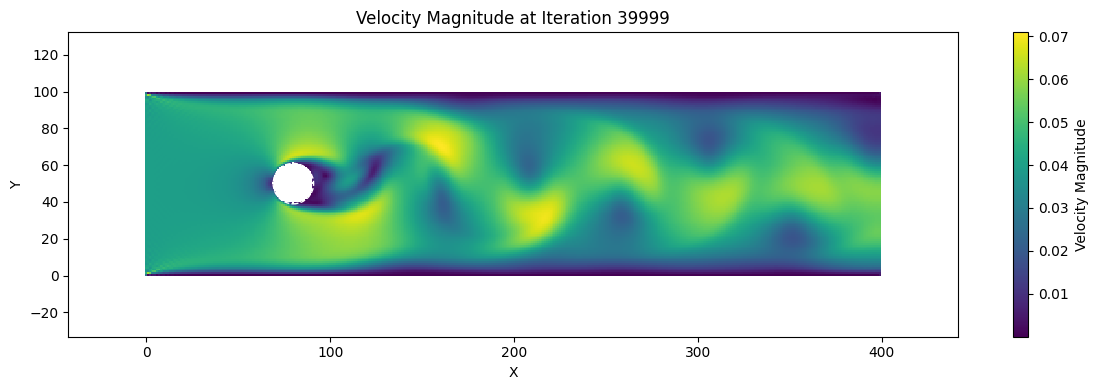

Freed GPU memory used by LBM arrays.


In [4]:
# Cell 3: Run LBM Simulation and Collect Snapshots
# -------------------------------------------------

# --- Data Storage (on CPU) ---
snapshots_u = []
snapshots_v = []
snapshot_times = [] # Store simulation time (iteration number)

# --- Main LBM Loop ---
print(f"Starting LBM Simulation ({'GPU' if gpu_available else 'CPU'})...")
start_time = time.time()

for it in tqdm(range(max_iters)):
    # Streaming (using xp.roll)
    for i in range(9):
        f[i] = xp.roll(f[i], shift=(c[i, 0].item(), c[i, 1].item()), axis=(0, 1)) # Use item() to get scalar shift

    # Store pre-collision state for bounce-back
    f_post_stream = f.copy()

    # Calculate macroscopic variables (needed for BCs and collision)
    rho = get_rho(f)
    ux, uy = get_uv(f, rho)

    # Boundary Conditions
    # Inlet (Zou-He velocity)
    ux_in = xp.full(Ny, u_lb)
    uy_in = xp.zeros(Ny)
    # Calculate rho_in based on the populations arriving from the interior
    rho_in = (f[0, 0, :] + f[2, 0, :] + f[4, 0, :] +
              2 * (f[3, 0, :] + f[6, 0, :] + f[7, 0, :])) / (1.0 - ux_in) # Assuming ux=u_lb here
    feq_in = equilibrium(rho_in, ux_in, uy_in) # Calculate equilibrium at inlet
    # Set unknown populations based on equilibrium
    f[1, 0, :] = feq_in[1, 0, :]
    f[5, 0, :] = feq_in[5, 0, :]
    f[8, 0, :] = feq_in[8, 0, :]

    # Outlet (Simple extrapolation - zero gradient)
    f[:, -1, :] = f[:, -2, :]

    # Top/Bottom Walls (Bounce-back using pre-streamed values)
    # Use xp indexing
    f[2, :, 0]  = f_post_stream[4, :, 0]
    f[5, :, 0]  = f_post_stream[7, :, 0]
    f[6, :, 0]  = f_post_stream[8, :, 0]
    f[4, :, -1] = f_post_stream[2, :, -1]
    f[7, :, -1] = f_post_stream[5, :, -1]
    f[8, :, -1] = f_post_stream[6, :, -1]

    # Cylinder (Bounce-back using pre-streamed values)
    # Apply bounce-back only on the cylinder boundary nodes
    # More efficient: apply bb only where cylinder_mask is True
    for i in range(9):
         # Reverse direction i using c_rev
         rev_i = c_rev[i].item()
         # Apply bounce back where cylinder_mask is True
         f[i, cylinder_mask] = f_post_stream[rev_i, cylinder_mask]


    # Collision
    # Recalculate rho, ux, uy AFTER applying all BCs
    rho = get_rho(f)
    ux, uy = get_uv(f, rho)

    # Set velocity inside cylinder to zero (important!)
    ux = xp.where(cylinder_mask, 0.0, ux)
    uy = xp.where(cylinder_mask, 0.0, uy)

    # Calculate equilibrium distribution
    feq = equilibrium(rho, ux, uy)

    # Perform collision step (BGK)
    f = f - (1.0 / tau) * (f - feq)

    # Save snapshot data (transfer to CPU here)
    # Start saving after initial transient phase
    start_saving_iter = max_iters // 4
    if it >= start_saving_iter and it % save_interval == 0:
        # Get current velocity field
        rho_snap = get_rho(f)
        ux_snap, uy_snap = get_uv(f, rho_snap)

        # Select only fluid points using the pre-calculated fluid_mask
        u_fluid = ux_snap[fluid_mask]
        v_fluid = uy_snap[fluid_mask]

        # Transfer data from GPU (if applicable) to CPU NumPy array
        if gpu_available:
            u_snap_cpu = xp.asnumpy(u_fluid.flatten())
            v_snap_cpu = xp.asnumpy(v_fluid.flatten())
        else:
            u_snap_cpu = u_fluid.flatten() # Already numpy
            v_snap_cpu = v_fluid.flatten()

        # Append CPU numpy arrays to lists
        snapshots_u.append(u_snap_cpu)
        snapshots_v.append(v_snap_cpu)
        snapshot_times.append(it)
        # Optional: Print progress within the loop if needed
        # if len(snapshots_u) % 10 == 0:
        #    print(f"   Saved snapshot {len(snapshots_u)} at iteration {it}")


end_time = time.time()
print(f"\nSimulation finished in {end_time - start_time:.2f} seconds.")
print(f"Collected {len(snapshots_u)} snapshots.")

# --- Visualize Last Frame  ---
if snapshots_u:
    print("Visualizing final state...")
    # Get final state and transfer to CPU for plotting
    rho_last = get_rho(f)
    ux_last, uy_last = get_uv(f, rho_last)
    ux_last = xp.where(cylinder_mask, xp.nan, ux_last) # Mask cylinder for plotting
    uy_last = xp.where(cylinder_mask, xp.nan, uy_last)

    if gpu_available:
        ux_plot = xp.asnumpy(ux_last)
        uy_plot = xp.asnumpy(uy_last)
        cylinder_mask_plot = xp.asnumpy(cylinder_mask)
    else:
        ux_plot = ux_last
        uy_plot = uy_last
        cylinder_mask_plot = cylinder_mask # Already numpy

    plt.figure(figsize=(12, 4))
    magnitude = np.sqrt(ux_plot**2 + uy_plot**2)
    plt.imshow(magnitude.T, cmap='viridis', origin='lower', interpolation='nearest')
    plt.colorbar(label='Velocity Magnitude')
    # Draw cylinder outline
    circle = plt.Circle((cylinder_x, cylinder_y), cylinder_r, color='white', fill=False, linestyle='--')
    plt.gca().add_patch(circle)
    plt.title(f'Velocity Magnitude at Iteration {it}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis('equal') # Ensure aspect ratio is correct
    plt.tight_layout()
    plt.show()
else:
    print("No snapshots were saved. Check simulation parameters (max_iters, save_interval). Cannot proceed.")
    # Consider raising an error here if snapshots are essential
    # raise RuntimeError("Snapshot collection failed.")

# Clear large GPU arrays if needed (optional memory management)
if gpu_available:
    del f, feq, rho, ux, uy, f_post_stream, ux_last, uy_last, rho_last, rho_snap, ux_snap, uy_snap
    cp.get_default_memory_pool().free_all_blocks()
    print("Freed GPU memory used by LBM arrays.")


Performing POD Analysis on CPU...
Snapshot matrix shape: (79246, 150)
Mean field shape: (79246, 1)
Mean-subtracted matrix shape (X): (79246, 150)
Computing SVD...
SVD computation took 0.65 seconds.
Selected 50 POD modes (out of 150) capturing >99.99% energy.
Truncated modes shape (U_r): (79246, 50)
Truncated coefficients shape (coeffs_r): (50, 150)
Scaled coefficients shape: (50, 150)


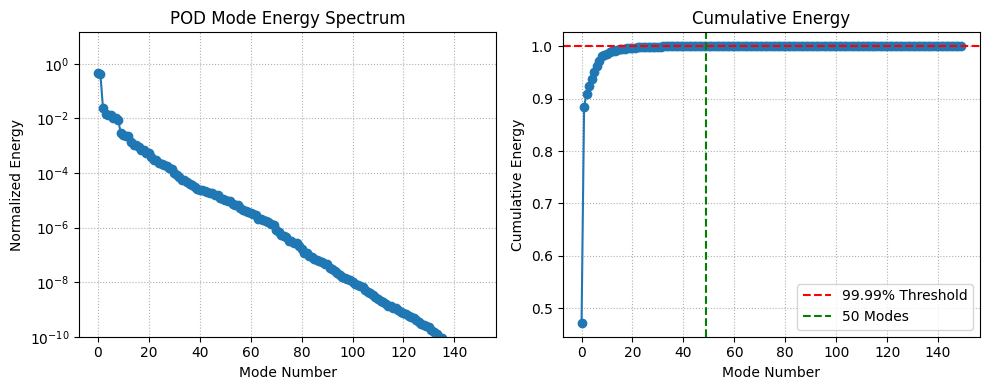

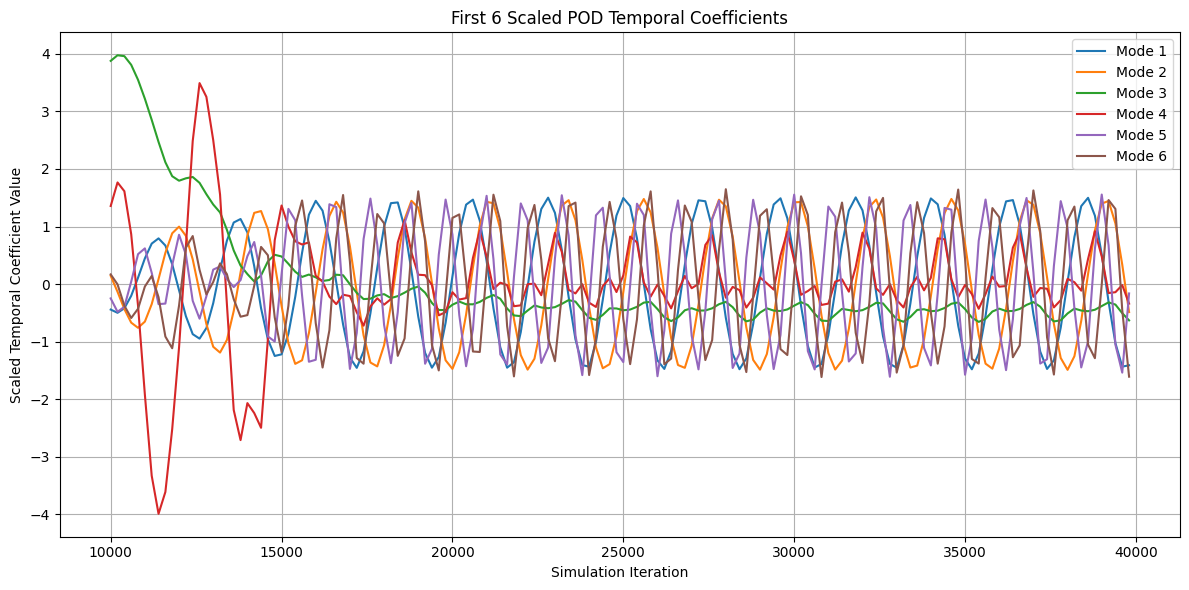

In [ ]:
# Cell 4: Perform POD Analysis
# -----------------------------
if not snapshots_u:
     print("Skipping POD and FNO due to missing snapshots.")
else:
    print("\nPerforming POD Analysis on CPU...")
    # --- Prepare data for POD ---
    # Combine u and v snapshots. Each column is a flattened (u, v) field at one time step.
    # These snapshots are already NumPy arrays on the CPU.
    snapshot_matrix_u = np.array(snapshots_u).T # Shape: (N_points_fluid, N_snapshots)
    snapshot_matrix_v = np.array(snapshots_v).T # Shape: (N_points_fluid, N_snapshots)
    snapshot_matrix = np.vstack((snapshot_matrix_u, snapshot_matrix_v))
    # Shape: (2 * N_points_fluid, N_snapshots)

    del snapshot_matrix_u, snapshot_matrix_v # Free memory
    print(f"Snapshot matrix shape: {snapshot_matrix.shape}")

    # --- Perform POD ---
    # 1. Subtract time mean
    mean_field = np.mean(snapshot_matrix, axis=1, keepdims=True)
    X = snapshot_matrix - mean_field
    print(f"Mean field shape: {mean_field.shape}")
    print(f"Mean-subtracted matrix shape (X): {X.shape}")

    # 2. Compute SVD using NumPy (runs on CPU)
    print("Computing SVD...")
    start_svd = time.time()
    # U contains spatial modes (POD modes)
    # S contains singular values (related to energy)
    # Vh contains temporal information (related to coefficients)
    U, S, Vh = np.linalg.svd(X, full_matrices=False) # Use reduced SVD
    end_svd = time.time()
    print(f"SVD computation took {end_svd - start_svd:.2f} seconds.")

    # 3. Calculate Temporal Coefficients
    # Project mean-subtracted data onto modes: coeffs = U.T @ X
    # Or directly from SVD: coeffs = np.diag(S) @ Vh (more efficient)
    coeffs = np.diag(S) @ Vh
    # Shape: (N_modes, N_snapshots) where N_modes = N_snapshots initially

    # 4. Select number of modes (e.g., based on energy)
    explained_variance = (S**2) / np.sum(S**2)
    cumulative_variance = np.cumsum(explained_variance)
    energy_threshold = 0.9999 # Capture 99.99% energy
    n_modes_pod = np.argmax(cumulative_variance >= energy_threshold) + 1
    print(f"Selected {n_modes_pod} POD modes (out of {len(S)}) capturing >{energy_threshold*100}% energy.")

    # Truncate modes and coefficients
    U_r = U[:, :n_modes_pod]        # Truncated spatial modes (Shape: N_spatial_points, n_modes_pod)
    coeffs_r = coeffs[:n_modes_pod, :] # Truncated temporal coefficients (Shape: n_modes_pod, N_snapshots)

    # Clear large SVD arrays
    del U, S, Vh, X
    print(f"Truncated modes shape (U_r): {U_r.shape}")
    print(f"Truncated coefficients shape (coeffs_r): {coeffs_r.shape}")


    # --- Standardize Coefficients ---
    # Scaling temporal coefficients often helps NN training
    scaler = StandardScaler()
    coeffs_scaled = scaler.fit_transform(coeffs_r.T).T # Scale across time dimension
    print(f"Scaled coefficients shape: {coeffs_scaled.shape}")


    # --- Visualize POD Results (Optional) ---
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.semilogy(explained_variance, 'o-')
    plt.xlabel('Mode Number')
    plt.ylabel('Normalized Energy')
    plt.title('POD Mode Energy Spectrum')
    plt.grid(True, which='both', linestyle=':')
    plt.ylim(bottom=1e-10) # Adjust if needed

    plt.subplot(1, 2, 2)
    plt.plot(cumulative_variance, 'o-')
    plt.axhline(energy_threshold, color='r', linestyle='--', label=f'{energy_threshold*100}% Threshold')
    plt.axvline(n_modes_pod - 1, color='g', linestyle='--', label=f'{n_modes_pod} Modes')
    plt.xlabel('Mode Number')
    plt.ylabel('Cumulative Energy')
    plt.title('Cumulative Energy')
    plt.legend()
    plt.grid(True, which='both', linestyle=':')
    plt.tight_layout()
    plt.show()

    # Plot first few scaled temporal coefficients
    plt.figure(figsize=(12, 6))
    n_coeffs_plot = min(6, n_modes_pod)
    for i in range(n_coeffs_plot):
        plt.plot(snapshot_times, coeffs_scaled[i, :], label=f'Mode {i+1}')
    plt.xlabel('Simulation Iteration')
    plt.ylabel('Scaled Temporal Coefficient Value')
    plt.title(f'First {n_coeffs_plot} Scaled POD Temporal Coefficients')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Preparing data for FNO...
FNO Input shape (X): torch.Size([138, 50, 12])
FNO Output shape (y): torch.Size([138, 50])
Training samples: 110, Validation samples: 28

FNO Model Architecture:
FNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SpectralConv(
        (weight): DenseTensor(shape=torch.Size([128, 128, 6]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(128, 128, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
          (1): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(51, 256, kernel_size=(1,), stride=(1,))
      (1): Conv1d(25

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1/80], Train Loss: 0.883464, Val Loss: 0.936227


Epoch 2/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2/80], Train Loss: 0.853071, Val Loss: 0.937220


Epoch 3/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [3/80], Train Loss: 0.851036, Val Loss: 0.938166


Epoch 4/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [4/80], Train Loss: 0.852085, Val Loss: 0.939333


Epoch 5/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [5/80], Train Loss: 0.807218, Val Loss: 0.941341


Epoch 6/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [6/80], Train Loss: 0.775838, Val Loss: 0.949627


Epoch 7/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [7/80], Train Loss: 0.720173, Val Loss: 0.966665


Epoch 8/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [8/80], Train Loss: 0.657301, Val Loss: 0.952448


Epoch 9/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [9/80], Train Loss: 0.589122, Val Loss: 0.955161


Epoch 10/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [10/80], Train Loss: 0.523901, Val Loss: 0.966797


Epoch 11/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [11/80], Train Loss: 0.483087, Val Loss: 0.954803


Epoch 12/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [12/80], Train Loss: 0.430122, Val Loss: 0.941689


Epoch 13/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [13/80], Train Loss: 0.392585, Val Loss: 0.940336


Epoch 14/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [14/80], Train Loss: 0.378705, Val Loss: 0.939865


Epoch 15/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [15/80], Train Loss: 0.369034, Val Loss: 0.938367


Epoch 16/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [16/80], Train Loss: 0.360027, Val Loss: 0.935493


Epoch 17/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [17/80], Train Loss: 0.351504, Val Loss: 0.930189


Epoch 18/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [18/80], Train Loss: 0.341696, Val Loss: 0.924021


Epoch 19/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [19/80], Train Loss: 0.331487, Val Loss: 0.919650


Epoch 20/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [20/80], Train Loss: 0.319836, Val Loss: 0.916554


Epoch 21/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 21/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [21/80], Train Loss: 0.318164, Val Loss: 0.915245


Epoch 22/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 22/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [22/80], Train Loss: 0.306622, Val Loss: 0.911944


Epoch 23/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 23/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [23/80], Train Loss: 0.293668, Val Loss: 0.906353


Epoch 24/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 24/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [24/80], Train Loss: 0.286297, Val Loss: 0.898760


Epoch 25/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 25/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [25/80], Train Loss: 0.275109, Val Loss: 0.890877


Epoch 26/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 26/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [26/80], Train Loss: 0.270300, Val Loss: 0.883860


Epoch 27/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 27/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [27/80], Train Loss: 0.255838, Val Loss: 0.877190


Epoch 28/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 28/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [28/80], Train Loss: 0.245609, Val Loss: 0.869249


Epoch 29/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 29/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [29/80], Train Loss: 0.236040, Val Loss: 0.860345


Epoch 30/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 30/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [30/80], Train Loss: 0.225033, Val Loss: 0.852158


Epoch 31/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 31/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [31/80], Train Loss: 0.210674, Val Loss: 0.843217


Epoch 32/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 32/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [32/80], Train Loss: 0.202634, Val Loss: 0.833369


Epoch 33/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 33/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [33/80], Train Loss: 0.187394, Val Loss: 0.823396


Epoch 34/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 34/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [34/80], Train Loss: 0.179356, Val Loss: 0.814798


Epoch 35/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 35/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [35/80], Train Loss: 0.168536, Val Loss: 0.803471


Epoch 36/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 36/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [36/80], Train Loss: 0.156657, Val Loss: 0.792381


Epoch 37/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 37/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [37/80], Train Loss: 0.145592, Val Loss: 0.782826


Epoch 38/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 38/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [38/80], Train Loss: 0.132778, Val Loss: 0.774750


Epoch 39/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 39/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [39/80], Train Loss: 0.121730, Val Loss: 0.765370


Epoch 40/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 40/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [40/80], Train Loss: 0.113964, Val Loss: 0.752776


Epoch 41/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 41/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [41/80], Train Loss: 0.102122, Val Loss: 0.742779


Epoch 42/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 42/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [42/80], Train Loss: 0.094261, Val Loss: 0.735199


Epoch 43/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 43/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [43/80], Train Loss: 0.086188, Val Loss: 0.724182


Epoch 44/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 44/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [44/80], Train Loss: 0.078924, Val Loss: 0.717439


Epoch 45/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 45/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [45/80], Train Loss: 0.071391, Val Loss: 0.710992


Epoch 46/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 46/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [46/80], Train Loss: 0.064483, Val Loss: 0.702823


Epoch 47/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 47/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [47/80], Train Loss: 0.057900, Val Loss: 0.693591


Epoch 48/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 48/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [48/80], Train Loss: 0.051248, Val Loss: 0.686718


Epoch 49/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 49/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [49/80], Train Loss: 0.046145, Val Loss: 0.683574


Epoch 50/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 50/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [50/80], Train Loss: 0.041031, Val Loss: 0.678864


Epoch 51/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 51/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [51/80], Train Loss: 0.035666, Val Loss: 0.668649


Epoch 52/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 52/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [52/80], Train Loss: 0.032009, Val Loss: 0.667705


Epoch 53/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 53/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [53/80], Train Loss: 0.028360, Val Loss: 0.663798


Epoch 54/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 54/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [54/80], Train Loss: 0.025599, Val Loss: 0.657150


Epoch 55/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 55/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [55/80], Train Loss: 0.022572, Val Loss: 0.656141


Epoch 56/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 56/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [56/80], Train Loss: 0.019881, Val Loss: 0.649143


Epoch 57/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 57/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [57/80], Train Loss: 0.018026, Val Loss: 0.646243


Epoch 58/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 58/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [58/80], Train Loss: 0.015813, Val Loss: 0.645427


Epoch 59/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 59/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [59/80], Train Loss: 0.014212, Val Loss: 0.640108


Epoch 60/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 60/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [60/80], Train Loss: 0.012792, Val Loss: 0.638170


Epoch 61/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 61/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [61/80], Train Loss: 0.011555, Val Loss: 0.636423


Epoch 62/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 62/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [62/80], Train Loss: 0.010636, Val Loss: 0.636200


Epoch 63/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 63/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [63/80], Train Loss: 0.009426, Val Loss: 0.633264


Epoch 64/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 64/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [64/80], Train Loss: 0.008737, Val Loss: 0.630360


Epoch 65/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 65/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [65/80], Train Loss: 0.007916, Val Loss: 0.629435


Epoch 66/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 66/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [66/80], Train Loss: 0.007320, Val Loss: 0.628412


Epoch 67/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 67/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [67/80], Train Loss: 0.006723, Val Loss: 0.627508


Epoch 68/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 68/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [68/80], Train Loss: 0.006152, Val Loss: 0.623407


Epoch 69/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 69/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [69/80], Train Loss: 0.005703, Val Loss: 0.623940


Epoch 70/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 70/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [70/80], Train Loss: 0.005251, Val Loss: 0.623783


Epoch 71/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 71/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [71/80], Train Loss: 0.004901, Val Loss: 0.620691


Epoch 72/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 72/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [72/80], Train Loss: 0.004492, Val Loss: 0.618875


Epoch 73/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 73/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [73/80], Train Loss: 0.004278, Val Loss: 0.618637


Epoch 74/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 74/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [74/80], Train Loss: 0.004013, Val Loss: 0.618969


Epoch 75/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 75/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [75/80], Train Loss: 0.003860, Val Loss: 0.617023


Epoch 76/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 76/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [76/80], Train Loss: 0.003622, Val Loss: 0.616015


Epoch 77/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 77/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [77/80], Train Loss: 0.003391, Val Loss: 0.614990


Epoch 78/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 78/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [78/80], Train Loss: 0.003339, Val Loss: 0.616566


Epoch 79/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 79/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [79/80], Train Loss: 0.003147, Val Loss: 0.614469


Epoch 80/80 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 80/80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [80/80], Train Loss: 0.003020, Val Loss: 0.614470
Training finished.


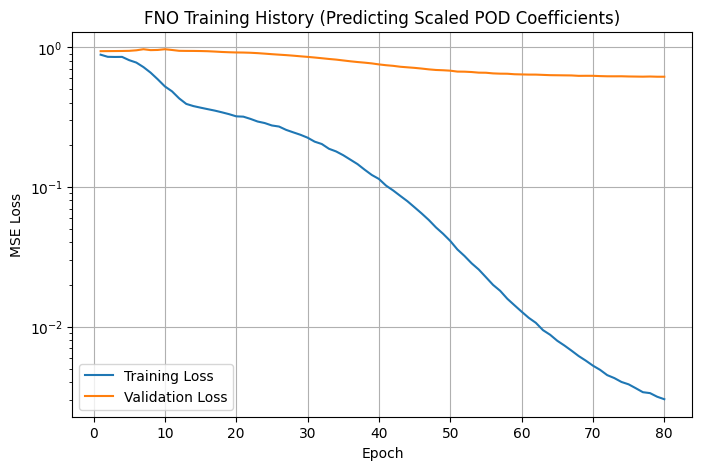

In [9]:
# Cell 5: Prepare Data and Train FNO
# ----------------------------------
from neuralop.models import FNO
if 'coeffs_scaled' not in locals():
     print("Skipping FNO training due to missing POD coefficients.")
else:
    print("\nPreparing data for FNO...")

    # We want FNO to predict the next set of coefficients based on a sequence of past coefficients.
    # Input: coeffs_scaled[:, t : t + sequence_len]
    # Output: coeffs_scaled[:, t + sequence_len]

    sequence_len = 12 # Use last N time steps to predict the next one (Hyperparameter)
    n_snapshots = coeffs_scaled.shape[1]

    X_fno_list = []
    y_fno_list = []

    if n_snapshots <= sequence_len:
        raise ValueError(f"Not enough snapshots ({n_snapshots}) to create sequences of length {sequence_len}.")

    for i in range(n_snapshots - sequence_len):
        X_fno_list.append(coeffs_scaled[:, i : i + sequence_len])
        y_fno_list.append(coeffs_scaled[:, i + sequence_len])

    # Convert to numpy arrays first (standard practice before tensor conversion)
    X_fno_np = np.array(X_fno_list, dtype=np.float32) # Shape: (N_samples, n_modes_pod, sequence_len)
    y_fno_np = np.array(y_fno_list, dtype=np.float32) # Shape: (N_samples, n_modes_pod)

    # Convert to PyTorch tensors
    X_fno_tensor = torch.from_numpy(X_fno_np)
    y_fno_tensor = torch.from_numpy(y_fno_np)

    print(f"FNO Input shape (X): {X_fno_tensor.shape}")
    print(f"FNO Output shape (y): {y_fno_tensor.shape}")

    # Split data into training and validation sets
    # Shuffle is important for time series when training sample-wise like this
    X_train, X_val, y_train, y_val = train_test_split(X_fno_tensor, y_fno_tensor, test_size=0.2, random_state=42, shuffle=True)

    print(f"Training samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}")

    # Create PyTorch DataLoaders
    batch_size = 64 # Adjust based on GPU memory
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True) # Use workers and pin memory if GPU available

    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    # --- Define FNO Model ---
    # FNO1d parameters - Tune these!
    fno_modes = 10   # Number of Fourier modes (<= sequence_len / 2)
    fno_width = 128  # Hidden channel dimension

    # Input dimension is n_modes_pod (channels), operating along sequence_len (the '1D' spatial dim)
    # Output dimension should also be n_modes_pod
    model = FNO(n_modes=(fno_modes,), # Tuple indicating modes in 1D
                  hidden_channels=fno_width,
                  in_channels=n_modes_pod,    # Number of POD modes
                  out_channels=n_modes_pod,   # Predicting all POD modes
                  n_layers=4,                 # Number of Fourier layers
                  use_mlp=True,
                  mlp_dropout=0.05,           # MLP dropout
                  mlp_expansion=1.0           # MLP expansion factor
                  ).to(device) # Move model to GPU if available

    print("\nFNO Model Architecture:")
    print(model)
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Number of trainable parameters: {num_params:,}")


    # --- Training Setup ---
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    # Scheduler reduces LR if validation loss plateaus
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=10, verbose=True)
    criterion = nn.MSELoss() # Use MSE for regression

    # --- Training Loop ---
    epochs = 80 # Adjust as needed
    print("\nStarting FNO training...")

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0.0
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
        for batch_x, batch_y in train_pbar:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device) # Move batch to device

            optimizer.zero_grad()
            # FNO outputs shape (batch, out_channels, sequence_len)
            output = model(batch_x)

            # We want the prediction for the *next* step. Index the last position.
            prediction = output[..., -1] # Shape: (batch, out_channels) == (batch, n_modes_pod)

            loss = criterion(prediction, batch_y)
            loss.backward()
            # Optional: Gradient clipping
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_train_loss += loss.item()
            train_pbar.set_postfix(loss=loss.item()) # Show loss in progress bar

        epoch_train_loss /= len(train_loader)
        train_losses.append(epoch_train_loss)

        # Validation
        model.eval()
        epoch_val_loss = 0.0
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False)
        with torch.no_grad():
            for batch_x, batch_y in val_pbar:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                output = model(batch_x)
                prediction = output[..., -1]
                loss = criterion(prediction, batch_y)
                epoch_val_loss += loss.item()
                val_pbar.set_postfix(loss=loss.item())

        epoch_val_loss /= len(val_loader)
        val_losses.append(epoch_val_loss)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_train_loss:.6f}, Val Loss: {epoch_val_loss:.6f}")

        # Learning rate scheduling step (based on validation loss)
        scheduler.step(epoch_val_loss)

        # Optional: Save best model checkpoint
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            #torch.save(model.state_dict(), 'best_fno_model.pth')
            #print(f"   -> Saved best model checkpoint (Val Loss: {best_val_loss:.6f})")


    print("Training finished.")

    # --- Plot Training History ---
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('FNO Training History (Predicting Scaled POD Coefficients)')
    plt.legend()
    plt.grid(True)
    plt.yscale('log') # Log scale often helpful for loss
    plt.show()


Evaluating FNO model on validation set...


Predicting on Val Set:   0%|          | 0/1 [00:00<?, ?it/s]

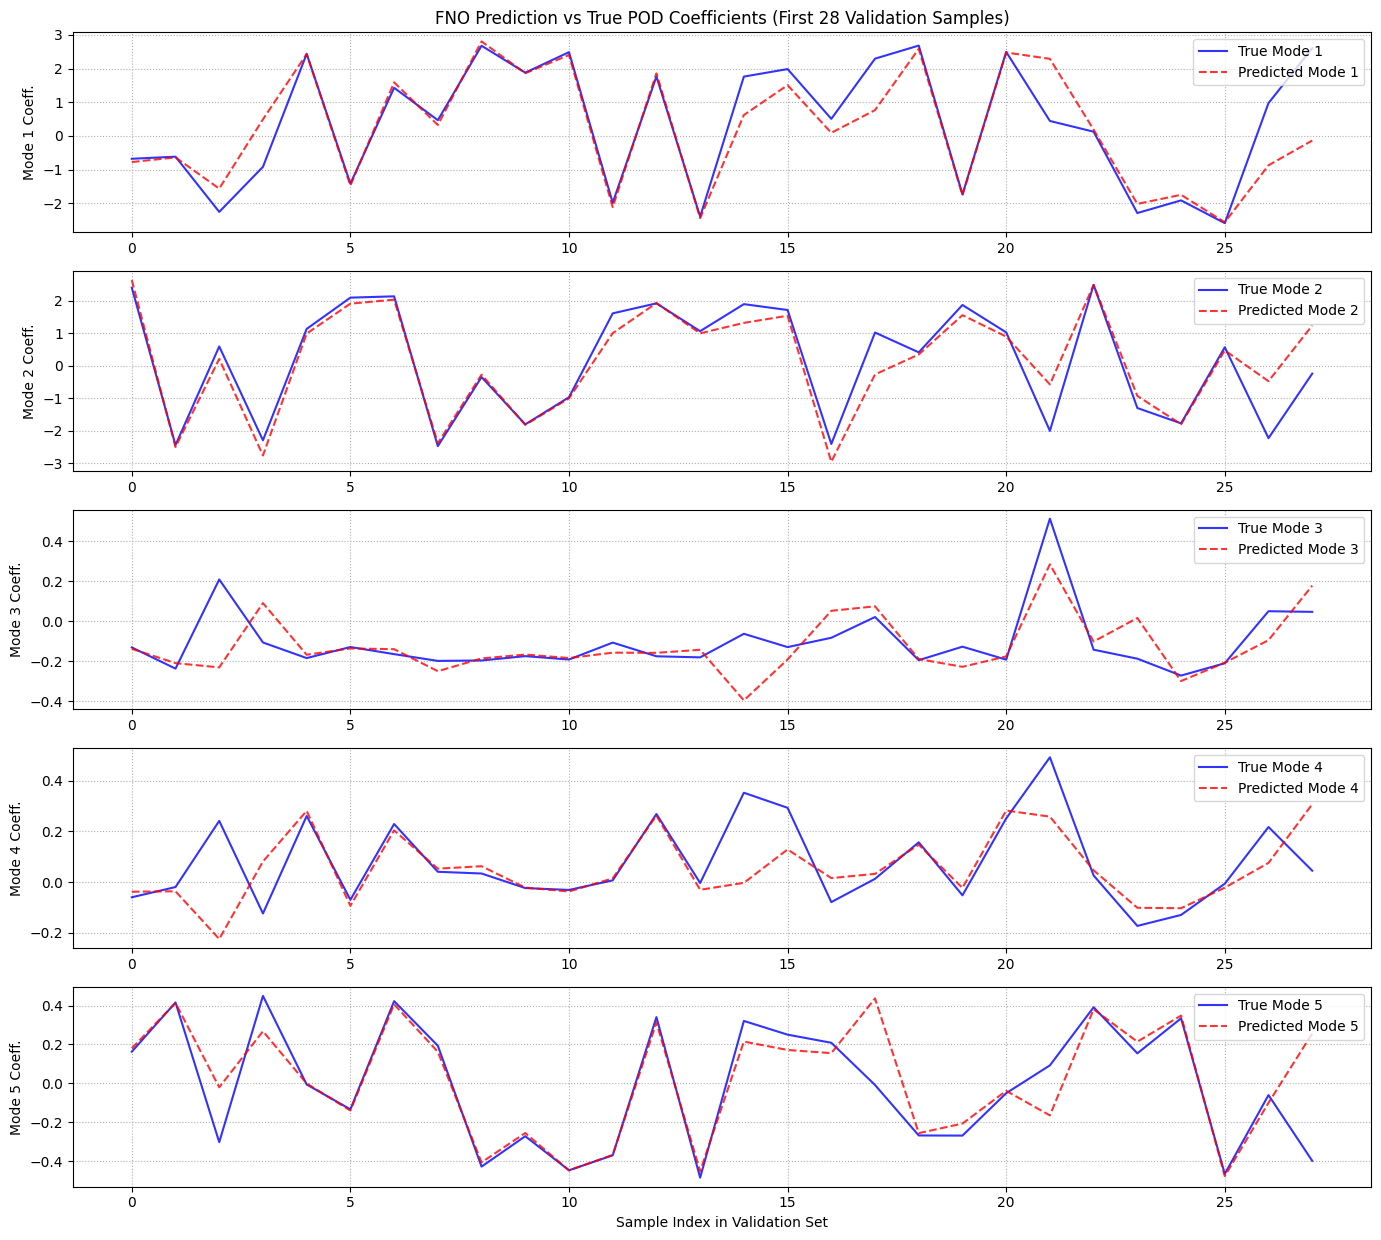


Reconstructing example flow field...


/tmp/ipykernel_31/2413125416.py:95: RuntimeWarning: invalid value encountered in sqrt
  mag_true = np.sqrt(u_true_full**2 + v_true_full**2)
/tmp/ipykernel_31/2413125416.py:96: RuntimeWarning: invalid value encountered in sqrt
  mag_pred = np.sqrt(u_pred_full**2 + v_pred_full**2)


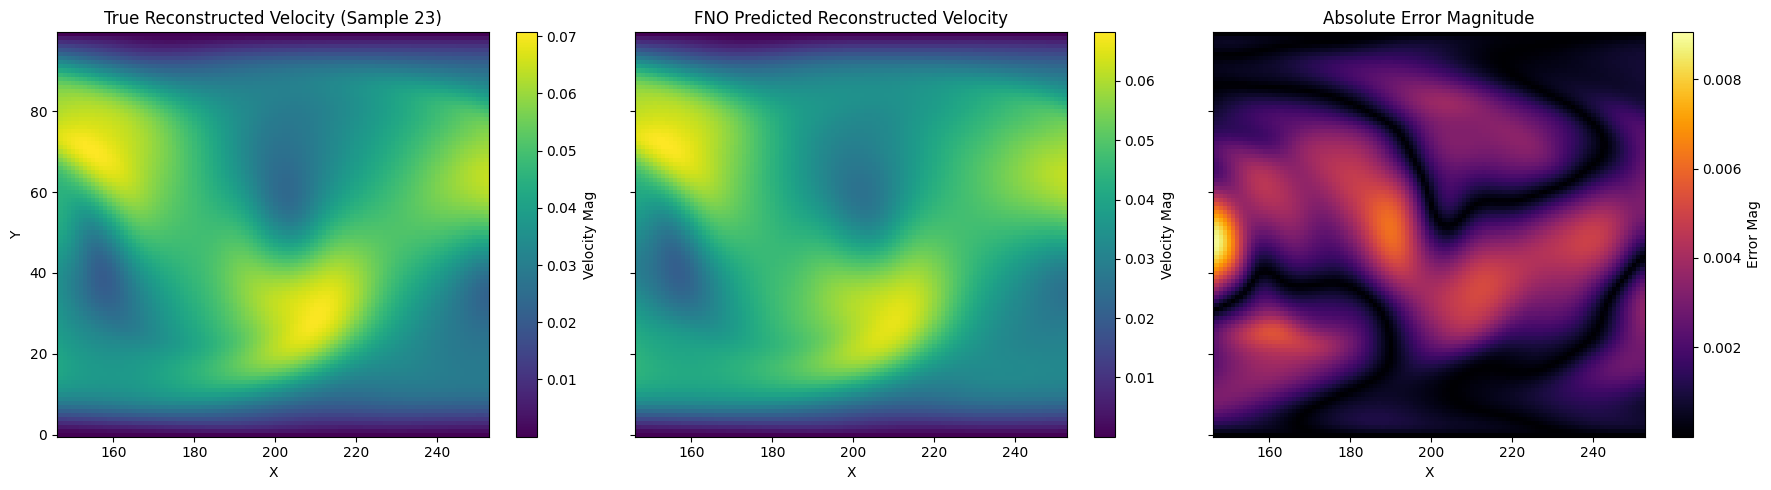


--- Relative Reconstruction Error ---
Relative L2 Error for sample 23: 6.8464e-02

--- Script Finished ---


In [10]:
# Cell 6: Evaluate FNO and Reconstruct Example Field
# --------------------------------------------------
if 'model' not in locals():
     print("Skipping FNO evaluation due to missing model.")
else:
    print("\nEvaluating FNO model on validation set...")
    model.eval()
    val_preds_list = []
    val_true_list = []

    with torch.no_grad():
        for batch_x, batch_y in tqdm(val_loader, desc="Predicting on Val Set"):
            batch_x = batch_x.to(device)
            output = model(batch_x)
            prediction = output[..., -1]
            val_preds_list.append(prediction.cpu().numpy()) # Move to CPU for numpy conversion
            val_true_list.append(batch_y.numpy()) # Ground truth is already on CPU from dataloader

    val_preds_scaled = np.concatenate(val_preds_list, axis=0)
    val_true_scaled = np.concatenate(val_true_list, axis=0)

    # Inverse transform to get original coefficient scale (optional, but good for interpretation)
    val_preds = scaler.inverse_transform(val_preds_scaled)
    val_true = scaler.inverse_transform(val_true_scaled)

    # --- Compare predictions for a few modes on the validation set ---
    n_coeffs_plot = min(5, n_modes_pod)
    plt.figure(figsize=(14, n_coeffs_plot * 2.5))
    plot_len = min(200, len(val_true)) # Plot a subset of validation points for clarity
    plot_indices = np.arange(plot_len)

    for i in range(n_coeffs_plot):
        plt.subplot(n_coeffs_plot, 1, i + 1)
        plt.plot(plot_indices, val_true[plot_indices, i], 'b-', label=f'True Mode {i+1}', alpha=0.8)
        plt.plot(plot_indices, val_preds[plot_indices, i], 'r--', label=f'Predicted Mode {i+1}', alpha=0.8)
        plt.ylabel(f'Mode {i+1} Coeff.')
        plt.legend(loc='upper right')
        plt.grid(True, linestyle=':')
        if i == 0:
            plt.title(f'FNO Prediction vs True POD Coefficients (First {plot_len} Validation Samples)')
        if i == n_coeffs_plot - 1:
            plt.xlabel('Sample Index in Validation Set')

    plt.tight_layout()
    plt.show()

    # --- Reconstruction Example ---
    print("\nReconstructing example flow field...")
    # Choose a sample from validation set (use original scaled versions for input)
    sample_idx = np.random.randint(0, len(X_val))
    input_seq_scaled = X_val[sample_idx].unsqueeze(0).to(device) # Scaled input, add batch dim, move to GPU

    # Predict the NEXT scaled coefficients
    with torch.no_grad():
        pred_output_scaled = model(input_seq_scaled)
        pred_coeffs_next_scaled = pred_output_scaled[..., -1].squeeze().cpu().numpy() # Scaled prediction, move to CPU

    # Get the TRUE next scaled coefficients for comparison
    true_coeffs_next_scaled = y_val[sample_idx].numpy() # Already scaled, on CPU

    # Inverse transform predicted and true coeffs to original scale for reconstruction
    pred_coeffs_next = scaler.inverse_transform(pred_coeffs_next_scaled.reshape(1, -1)).flatten()
    true_coeffs_next = scaler.inverse_transform(true_coeffs_next_scaled.reshape(1, -1)).flatten()

    # Reconstruct using POD modes (U_r - on CPU) and the mean field (mean_field - on CPU)
    true_reconstruction_flat = (U_r @ true_coeffs_next) + mean_field.flatten()
    pred_reconstruction_flat = (U_r @ pred_coeffs_next) + mean_field.flatten()

    # Reshape back into u, v fields for fluid points
    n_points_fluid = U_r.shape[0] // 2 # Number of fluid points where data was saved
    true_u_rec = true_reconstruction_flat[:n_points_fluid]
    true_v_rec = true_reconstruction_flat[n_points_fluid:]
    pred_u_rec = pred_reconstruction_flat[:n_points_fluid]
    pred_v_rec = pred_reconstruction_flat[n_points_fluid:]

    # Create full fields including cylinder area (assign NaN) - use NumPy
    u_true_full = np.full((Nx, Ny), np.nan)
    v_true_full = np.full((Nx, Ny), np.nan)
    u_pred_full = np.full((Nx, Ny), np.nan)
    v_pred_full = np.full((Nx, Ny), np.nan)

    # Get the fluid mask (needs to be NumPy array)
    if gpu_available:
         fluid_mask_np = xp.asnumpy(fluid_mask)
    else:
         fluid_mask_np = fluid_mask # Already numpy

    # Fill in the fluid points
    u_true_full[fluid_mask_np] = true_u_rec
    v_true_full[fluid_mask_np] = true_v_rec
    u_pred_full[fluid_mask_np] = pred_u_rec
    v_pred_full[fluid_mask_np] = pred_v_rec

    # Calculate magnitudes and error
    mag_true = np.sqrt(u_true_full**2 + v_true_full**2)
    mag_pred = np.sqrt(u_pred_full**2 + v_pred_full**2)
    error_mag = np.abs(mag_true - mag_pred)
    # Handle NaNs in error calculation if needed, though difference should be ok
    # error_mag = np.sqrt((u_true_full - u_pred_full)**2 + (v_true_full - v_pred_full)**2)

    # Plot comparison
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

    im0 = axes[0].imshow(mag_true.T, cmap='viridis', origin='lower', interpolation='nearest')
    axes[0].set_title(f'True Reconstructed Velocity (Sample {sample_idx})')
    axes[0].set_xlabel('X'); axes[0].set_ylabel('Y')
    fig.colorbar(im0, ax=axes[0], label='Velocity Mag')
    circle0 = plt.Circle((cylinder_x, cylinder_y), cylinder_r, color='white', fill=False, linestyle='--')
    axes[0].add_patch(circle0)
    axes[0].axis('equal')


    im1 = axes[1].imshow(mag_pred.T, cmap='viridis', origin='lower', interpolation='nearest')
    axes[1].set_title('FNO Predicted Reconstructed Velocity')
    axes[1].set_xlabel('X')
    fig.colorbar(im1, ax=axes[1], label='Velocity Mag')
    circle1 = plt.Circle((cylinder_x, cylinder_y), cylinder_r, color='white', fill=False, linestyle='--')
    axes[1].add_patch(circle1)
    axes[1].axis('equal')


    im2 = axes[2].imshow(error_mag.T, cmap='inferno', origin='lower', interpolation='nearest')
    axes[2].set_title('Absolute Error Magnitude')
    axes[2].set_xlabel('X')
    fig.colorbar(im2, ax=axes[2], label='Error Mag')
    circle2 = plt.Circle((cylinder_x, cylinder_y), cylinder_r, color='white', fill=False, linestyle='--')
    axes[2].add_patch(circle2)
    axes[2].axis('equal')

    plt.tight_layout()
    plt.show()

    print("\n--- Relative Reconstruction Error ---")
    # Calculate relative L2 error on the reconstructed field (only fluid points)
    norm_diff = np.linalg.norm(true_reconstruction_flat - pred_reconstruction_flat)
    norm_true = np.linalg.norm(true_reconstruction_flat)
    relative_error = norm_diff / norm_true if norm_true > 1e-9 else 0.0
    print(f"Relative L2 Error for sample {sample_idx}: {relative_error:.4e}")

print("\n--- Script Finished ---")